# Ejercicio 1

Codifique el algoritmo de entrenamiento para una red neuronal con RBF y pruebe su implementación en la resolución del problema `xor`, empleando los datos de la guía anterior.
Diseñe una red RBF para resolver el problema Iris (`irisbin.csv`), considerando una cantidad de parámetros similar a la red MLP de la guía anterior. 
Luego compare la velocidad de entrenamiento y el porcentaje final de clasificación obtenido con ambas arquitecturas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
rng = np.random.default_rng()

In [2]:
def generar_particiones(filename, n, p_test):
    ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx=np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (ds, M_test, M_train)

def sigmoidea(x):
    return np.divide(2, (1 + np.exp(-1 * x))) - 1

class layer:
    def __init__(self, NNeurons, NInputs):
        # Almacenar la dimensión de entrada y cantidad de neuronas
        self.neurons_ = NNeurons
        self.inputs_ = NInputs

        # Inicializar la matriz de pesos de N x M con valores aleatorios
        # con una distribución normal centrada en 0 y norma < 0.5 aprox 
        # self.w = np.random.normal(loc = 0, scale = 0.15, size = (NNeurons, NInputs))
        self.w = rng.random((NNeurons, NInputs))
        
    def eval(self, x):
        # Comprobar que la dimension de la entrada es igual a la incializada 
        assert x.shape[0] == self.inputs_, \
            f"La entrada de dimensión {x.shape[0]} no coincide con la declarada {self.inputs_}"

        # Producto interno entre la entrada y los pesos
        y = np.dot(self.w, x)
        
        # No linealidad
        z = sigmoidea(y)
        return z

class MultiLayerPerceptron:
    def __init__(self, neuronsPerLayer, NInputs):
        self.neuronsPerLayer_ = neuronsPerLayer
        self.NInputs = NInputs

        # La red estará representada como un arreglo de capas
        self.network_ = []
        
        # Auxiliar para definiar la cantidad de entradas de cada capa
        # La primera coincide con la entrada de la red
        NInputs_aux = NInputs

        # Para cada capa representada como el número de neuronas
        for layerNeurons in neuronsPerLayer:
            # Se crea una capa en base a la cantidad de salidas de la capa
            # anterior + 1 (el bias) y con el número de neuronas indicado
            self.network_.append(layer(layerNeurons, NInputs_aux + 1))
            
            # Adelantar la cantidad de entradas para la próxima capa
            NInputs_aux = layerNeurons

        # Arreglo auxiliar para almacenar los gradientes instantáneos
        self.grad_ = []
    
    def eval(self, input):
        # Comprobar que la dimension de la entrada es igual a la incializada 
        assert input.shape[0] == self.NInputs, \
            f"La entrada de dimensión {input.shape[0]} no coincide con la declarada {self.NInputs}"

        # La salida de cada capa será acumulada en un arreglo
        # que es devuelto para luego utilizar en la etapa de train
        y = [input]
        
        for i in range(len(self.network_)): # Para cada capa en la red
            # Agregar el bias a la entrada de la capa i (como primer componente)
            x_ = np.hstack((-1, y[i]))

            # Calcular la salida de la capa i
            y_ = self.network_[i].eval(x_)
            
            # Agregar la salida al arreglo, que será la entrada de la siguiente
            y.append(y_)
        
        # Devolver la salida como tal, y las salidas intermedias de cada capa
        return (y[-1], y)

    def backward(self, y, yd):
        # Comprobar que la dimension de la salida calculada es igual a la de la deseada 
        assert yd.shape[0] == y[-1].shape[0], \
            f"La dimensión de la salida deseada ({yd.shape[0]}) no coincide con la calculada ({y[-1].shape[0]})"
        
        # Comprobar que la dimension de la salida deseada es igual a la cantidad de neuronas de salida 
        assert yd.shape[0] == self.neuronsPerLayer_[-1], \
            f"La dimensión de la salida deseada ({yd.shape[0]}) no coincide con la capa de salida ({self.neuronsPerLayer_[-1]})"

        # Se calcula el error entre la salida de la red (último componente de y)
        # y la salida deseada (la dimensión será la cantidad de neuronas a la salida)
        error_ = yd - y[-1]

        # Reiniciar el vector de gradientes instantaneos
        self.grad_ = []

        # Calcular el gradiente de la capa de salida y guardarlo
        self.grad_.append((np.multiply(error_, np.multiply((1 + y[-1]), (1 - y[-1])))) * 0.5)
        
        # Recorriendo las capas desde la penultima hacia la de entrada
        for i in range(len(self.network_)-1,0,-1):
            # De la capa siguiente (en el orden forward), tomar la matriz de pesos
            # sin la columna de pesos asociados al bias, y transponerla (wT_)
            wT_ = self.network_[i].w[:,1:].T

            # Calcular el gradiente local instantaneo como el producto interno entre
            # wT_ y el gradiente de error local de esa misma capa (la siguiente en orden forward)
            # en lo que se conoce como retropropagación del error
            # TODO: chequear el indexado
            d_ = np.dot(wT_, self.grad_[len(self.network_)-1-i])

            # Luego multiplicar por la derivada de la sigmoidea
            g_ = (np.multiply(d_, np.multiply((1 + y[i]), (1 - y[i])))) * 0.5
            
            # Agregar al arreglo de gradientes
            self.grad_.append(g_)

    def update(self, y, lr):
        # Actualización de pesos para cada capa
        for i in range(len(self.network_)):
            # Se calcula el producto entre el gradiente local instantáneo de la capa 
            # con la entrada de la capa (con bias), esto multiplicado por la tasa
            # de aprendizaje resulta en la matriz de actualización de pesos
            Dw_ = lr * np.outer(self.grad_[-(i+1)], np.hstack((-1, y[i])))
            
            # Los nuevos pesos se calculan como el Delta + los pesos "viejos"
            self.network_[i].w = np.add(self.network_[i].w, Dw_)

In [3]:
def kMeans(x, k):
    # k define la cantidad de grupos
    # se toman k grupos y se le asigna a cada patrón un grupo aleatorio
    group_idx = np.repeat(range(k),np.ceil(x.shape[0]/k))[:x.shape[0]]

    vec_reasig = np.zeros(x.shape[0])
    cant_it = 0
    means_vec = np.zeros((k, x.shape[1]))
    stdev_vec = np.zeros((k, x.shape[1]))

    # mientras se hayan hecho reasignaciones (sale cuando todos son verdaderos -> no hubo reasignaciones)
    while vec_reasig.all() != True:
        cant_it += 1
        
        # se calculan los centroides de cada grupo
        for i in range(k):
            group = x[group_idx == i]
            # si hay algo en el grupo
            if(group.shape[0] > 0):
                means_vec[i] =  np.mean(group, axis = 0)
                # if(group.shape[0] > 1):
                #     stdev_vec[i] = np.std(group, axis = 0)

        
        # por cada patron
        for i, pattern in enumerate(x):
            dist_vec = []
            for i_group in range(k):
                # vector distancias entre el patron y los centroides
                dist_vec.append(np.linalg.norm(pattern - means_vec[i_group]))
            # índice del centroide que tiene menor distancia
            idx_min = np.argmin(dist_vec)
            # reasignación de grupo si es necesario
            if (group_idx[i] != idx_min):
                vec_reasig[i] == False
                group_idx[i] = idx_min
            # si no hay reasignación se pone en verdadero
            else:
                vec_reasig[i] = True
    
    for i in range(k):
        group = x[group_idx == i]
        # si hay algo en el grupo
        if(group.shape[0] > 1):
            stdev_vec[i] = np.std(group, axis = 0)
        else:
            stdev_vec[i] = 1
    print(np.histogram(group_idx,range(k+1)))
            
    return group_idx, stdev_vec, means_vec, cant_it

In [4]:
def f_gaussian(x, c, mu):
    # desvío fijo, igual al promedio entre el desvío de cada dimensión
    mu = np.ones_like(mu) * np.mean(mu)
    d_ = np.subtract(x, c)
    c_ = np.diag(1 / mu)
    # HAY QUE CHECKEAR LO DE LA DESVIACION POR QUE
    #PONIENDOLA FIJA QUE ES LA SALVEDAD MAS SIMPLEMQUE DIJO DIPERSIA EL CODIGO ANDA.
    y = np.exp(-0.5 * np.dot(np.dot(d_.T, c_), d_))
    return y

## Problema XOR

In [5]:
ds, testPartitionsIdx, trainPartitionsIdx  =  generar_particiones('gtp2datos/XOR_trn.csv', 1, 0.2)

# Separar patrones para validación
# Cantidad de patrones para entrenamiento
NPatternsTrain = trainPartitionsIdx.shape[1]
# Cantidad de patrones a separar para validación
NPatternsValidation = 100
#variable que indica el numero de salidas que tiene el dataset
y_num=1
# Generar el vector de entradas para entrenamiento y validación (solo una partición)
#X_val = ds[trainPartitionsIdx[0, :NPatternsValidation], :-1]
X = ds[trainPartitionsIdx[0], :-y_num]
# Generar el vector de salida deseada para entrenamiento y validación
#Yd_val = ds[trainPartitionsIdx[0, :NPatternsValidation], -1]
Yd = ds[trainPartitionsIdx[0], -y_num].reshape((-1,y_num))

### Capa radial

In [6]:
k = 4      # cantidad de grupos / RBF

# [puede ser que queden grupos vacíos?]
idx_groups, std_vec, means_vec, cant_it = kMeans(X, k)

(array([806, 410,   0, 384], dtype=int64), array([0, 1, 2, 3, 4]))


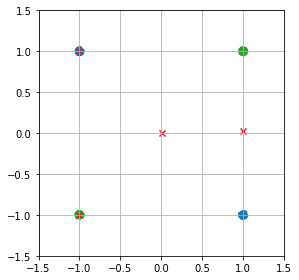

In [7]:
fig1 = plt.figure(figsize=(5, 4), tight_layout=True)
# fig1.suptitle('Recta $w_1 x + w_2 y - w_0 = 0$',  fontsize=11)
fig1_ax = fig1.add_subplot(autoscale_on=False, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))
fig1_ax.set_aspect('equal')
fig1_ax.grid()

# Patrones
x_x = X[:,0]
x_y = X[:,1]
x_color = np.where(Yd[:,0] == 1, 'C0', 'C2')
fig1_ax.scatter(x_x, x_y, c=x_color, s=5, marker='.')

# k-means
fig1_ax.scatter(means_vec[:,0], means_vec[:,1], marker='x', c='C3')

plt.show()

In [8]:
# salidas de las RBF -> entradas del mlp
mlp_in = np.zeros((X.shape[0], k))

# por cada patrón, se calcula la salida de la capa radial pasando por la RBF
for i, pattern in enumerate(X):

    _aux = [f_gaussian(pattern, _mean, _mu) for (_mean, _mu) in zip(means_vec, std_vec)]
    mlp_in[i] = _aux

### Entrenamiento de Perceptrón

In [9]:
#perceptrón
layerStack = np.array([y_num])
perceptron_simple = MultiLayerPerceptron(layerStack, k)

# Parámetros de entrenamiento
NEpoch = 5000           # Cantidad de épocas máximas (anterior 2000)
errorThr = 0.2         # Umbral de error para finalizar (anterior 0.005)
lr = 5E-3                # Tasa de aprendizaje (anterior 8E-3)

mlp_in.shape

(1600, 4)

In [10]:
# Arreglos auxiliares para guardar la evolución del error de la red
errorRatePerEpoch = []
MMSEPerEpoch = []

for epoch in range(NEpoch): # Para cada época
    for pattern, yd in zip(mlp_in, Yd): # Para cada patrón en la partición
        # Calcular la salida según los pesos actuales (pasada hacia adelante)
        (_, y_) = perceptron_simple.eval(pattern)
        #print(f'salida{_}={y_}')

        # Realizar la propagación hacia atrás donde se calculan los gradientes
        # instantáneos (pasada hacia atrás)
        perceptron_simple.backward(y_, yd)
        
        # Actualizar los pesos de la red
        perceptron_simple.update(y_, lr)
    
    # Para la validación se utilizarán solo algunos patrones y se calculará una
    # tasa de error, si esta es menor al umbral, se termina el proceso de entrenamiento
    # A la vez, se calculará el error cuadrático medio para tener una evolución
    # de dicha variable a lo largo de las épocas
    errorsAccum_ = 0    # Acumulador de errores
    SEAcumm_ = 0        # Acumulador error cuadrático

    # [valido con todos los patrones]
    for patron, yd in zip(mlp_in, Yd):
        # Evaluar el patron
        (z_, _) = perceptron_simple.eval(patron)
        
        #CODIFICACION
        y_ = -1 if (z_[-1] < 0) else 1
  
        
        # Comparación con la salida deseada y acumulación de errores
        errorsAccum_ += int(np.any(np.not_equal(y_, yd)))
  
        # Cálculo del error cuadrático y acumulación
        SEAcumm_ += np.sum(np.square(yd - z_))

    # Tasa de error: errores / patrones evaluados
    errorRate_ = (errorsAccum_/X.shape[0])
    # Guardar la tasa de error de1000 la época
    errorRatePerEpoch= np.append(errorRatePerEpoch, [errorRate_])
    
    # Calcular el error cuadrático medio promedio: MSE / patrones evaluados
    MSEMean_= (SEAcumm_/X.shape[0])
    # Guardar el error cuadrático medio promedio de la época
    MMSEPerEpoch = np.append(MMSEPerEpoch, MSEMean_)

    # Si la tasa de error es menor al umbral, termina el proceso de entrenamiento
    if (errorRate_ < errorThr):
        break

    # Cada 100 épocas mostrar el error
    # if (epoch+1) % 100 == 0:
    #     print(f'Época {epoch+1}: tasa de error de {errorRatePerEpoch[-1]} | MSE promedio {MMSEPerEpoch[-1]}')
   
# Imprimir información acerca del entrenamiento
print(f'Finalizó en la época {epoch+1} con una tasa de error de {errorRatePerEpoch[-1]}')

Finalizó en la época 97 con una tasa de error de 0.198125


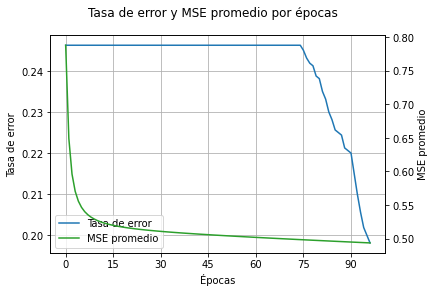

In [11]:
# Gráfica de la tasa de error por época junto con el MSE promedio por época
epochs = errorRatePerEpoch.shape[0]
xx_ = range(epochs)

fig1, fig1_ax = plt.subplots()
fig1.suptitle("Tasa de error y MSE promedio por épocas")
fig1_ax.set_xlabel('Épocas')
fig1_ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Solo ticks en enteros
fig1_ax.grid()
fig1_ax.set_ylabel('Tasa de error')

fig1_plot1 = fig1_ax.plot(xx_, errorRatePerEpoch, label='Tasa de error')

fig1_ax2 = fig1_ax.twinx()
fig1_plot2 = fig1_ax2.plot(xx_, MMSEPerEpoch, label='MSE promedio', color='C2')
fig1_ax2.set_ylabel('MSE promedio')

# added these three lines
lns = fig1_plot1+fig1_plot2
labs = [l.get_label() for l in lns]
fig1_ax.legend(lns, labs, loc=0)

plt.show()

### Test

In [12]:
# Procesar los datos para test
# Generar el vector de entradas para test
XTest = ds[testPartitionsIdx[0,:], :-y_num]
# Generar el vector de salida deseada para test
YdTest = ds[testPartitionsIdx[0,:], -y_num]

mlp_in_test = np.zeros((XTest.shape[0], k))

# por cada patrón, se calcula la salida de la capa radial pasando por la RBF
for i, pattern in enumerate(XTest):
    _aux = [f_gaussian(pattern, _mean, _mu) for (_mean, _mu) in zip(means_vec, std_vec)]
    mlp_in_test[i] = _aux / np.linalg.norm(_aux)

errorsAccum_ = 0     # Acumulador de errores
for pattern, yd in zip(mlp_in_test, YdTest):
    # Calcular la salida
    (z_, _) = perceptron_simple.eval(pattern)
    
    # Codificación de la salida
    y_ = -1 if (z_[-1] < 0) else 1
    
    # Comparación con la salida deseada y acumulación de errores
    errorsAccum_ += int(y_ != yd)

print(f'Tasa de error en prueba {errorsAccum_ / XTest.shape[0]}')

Tasa de error en prueba 0.27


## Problema irisbin


In [13]:
ds, testPartitionsIdx, trainPartitionsIdx  =  generar_particiones('gtp2datos/irisbin.csv', 1, 0.2)
# Separar patrones para validación
# Cantidad de patrones para entrenamiento
NPatternsTrain = trainPartitionsIdx.shape[1]
# Cantidad de patrones a separar para validación
NPatternsValidation = 100
#variable que indica la cantidad de salidas en el dataset
y_num=3


#NO ESTAREMOS CAMBIANDO EL DATA SET ACA?

# Generar el vector de entradas para entrenamiento y validación (solo una partición)
#X_val = ds[trainPartitionsIdx[0, :NPatternsValidation], :-1]
X = ds[trainPartitionsIdx[0], :-y_num]
# Generar el vector de salida deseada para entrenamiento y validación
#Yd_val = ds[trainPartitionsIdx[0, :NPatternsValidation], -1]
Yd = ds[trainPartitionsIdx[0], -y_num:]

# X = ds[trainPartitionsIdx[0], :-y_num]
# # Generar el vector de salida deseada para entrenamiento y validación
# #Yd_val = ds[trainPartitionsIdx[0, :NPatternsValidation], -1]
# Yd = ds[trainPartitionsIdx[0], -y_num].reshape((-1,y_num))

### Capa radial

In [14]:
k = 10       # cantidad de grupos / RBF

idx_groups, std_vec, means_vec, cant_it = kMeans(X, k)

(array([31,  0, 47,  0,  1,  1,  8, 32,  0,  0], dtype=int64), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))


In [15]:
# salidas de las RBF -> entradas del mlp
mlp_in = np.zeros((X.shape[0], k))

# por cada patrón, se calcula la salida de la capa radial pasando por la RBF
for i, pattern in enumerate(X):

    _aux = [f_gaussian(pattern, _mean, _mu) for (_mean, _mu) in zip(means_vec, std_vec)]
    mlp_in[i] = _aux

### Entrenamiento del perceptrón

In [16]:
#perceptrón
layerStack = np.array([y_num])
perceptron_simple = MultiLayerPerceptron(layerStack, k)

# Parámetros de entrenamiento
NEpoch = 5000           # Cantidad de épocas máximas (anterior 2000)
errorThr = 0.03         # Umbral de error para finalizar (anterior 0.005)
lr = 5E-3                # Tasa de aprendizaje (anterior 8E-3)

mlp_in.shape

(120, 10)

In [17]:
# Arreglos auxiliares para guardar la evolución del error de la red
errorRatePerEpoch = []
MMSEPerEpoch = []

for epoch in range(NEpoch): # Para cada época
    for pattern, yd in zip(mlp_in, Yd): # Para cada patrón en la partición
        # Calcular la salida según los pesos actuales (pasada hacia adelante)
        (_, y_) = perceptron_simple.eval(pattern)
        #print(f'salida{_}={y_}')

        # Realizar la propagación hacia atrás donde se calculan los gradientes
        # instantáneos (pasada hacia atrás)
        perceptron_simple.backward(y_, yd)
        
        # Actualizar los pesos de la red
        perceptron_simple.update(y_, lr)
    
    # Para la validación se utilizarán solo algunos patrones y se calculará una
    # tasa de error, si esta es menor al umbral, se termina el proceso de entrenamiento
    # A la vez, se calculará el error cuadrático medio para tener una evolución
    # de dicha variable a lo largo de las épocas
    errorsAccum_ = 0    # Acumulador de errores
    SEAcumm_ = 0        # Acumulador error cuadrático

    # [valido con todos los patrones]
    for patron, yd in zip(mlp_in, Yd):
        # Evaluar el patron
        (z_, _) = perceptron_simple.eval(patron)
      
        #CODIFICACION
        if z_[0] == z_.max():
            y_ = [1, -1, -1]
        elif z_[1] == z_.max():
            y_ = [-1, 1, -1]
        else:
             y_ = [-1, -1, 1]
  
        # Comparación con la salida deseada y acumulación de errores
        errorsAccum_ += int(np.any(np.not_equal(y_, yd)))
  
        # Cálculo del error cuadrático y acumulación
        SEAcumm_ += np.sum(np.square(yd - z_))

    # Tasa de error: errores / patrones evaluados
    errorRate_ = (errorsAccum_/X.shape[0])
    # Guardar la tasa de error de1000 la época
    errorRatePerEpoch= np.append(errorRatePerEpoch, [errorRate_])
    
    # Calcular el error cuadrático medio promedio: MSE / patrones evaluados
    MSEMean_= (SEAcumm_/X.shape[0])
    # Guardar el error cuadrático medio promedio de la época
    MMSEPerEpoch = np.append(MMSEPerEpoch, MSEMean_)

    # Si la tasa de error es menor al umbral, termina el proceso de entrenamiento
    if (errorRate_ < errorThr):
        break

    # Cada 100 épocas mostrar el error
    if (epoch+1) % 100 == 0:
        print(f'Época {epoch+1}: tasa de error de {errorRatePerEpoch[-1]} | MSE promedio {MMSEPerEpoch[-1]}')
   
# Imprimir información acerca del entrenamiento
print(f'Finalizó en la época {epoch+1} con una tasa de error de {errorRatePerEpoch[-1]}')

Época 100: tasa de error de 0.03333333333333333 | MSE promedio 0.5391662089865324
Época 200: tasa de error de 0.03333333333333333 | MSE promedio 0.3983818899995034
Época 300: tasa de error de 0.03333333333333333 | MSE promedio 0.3468002556236643
Época 400: tasa de error de 0.03333333333333333 | MSE promedio 0.3186080807830459
Época 500: tasa de error de 0.03333333333333333 | MSE promedio 0.3001688281923021
Época 600: tasa de error de 0.05 | MSE promedio 0.28679764892560816
Época 700: tasa de error de 0.05 | MSE promedio 0.2764321259880396
Época 800: tasa de error de 0.05 | MSE promedio 0.2680153817511402
Época 900: tasa de error de 0.05 | MSE promedio 0.2609465300962371
Finalizó en la época 973 con una tasa de error de 0.025


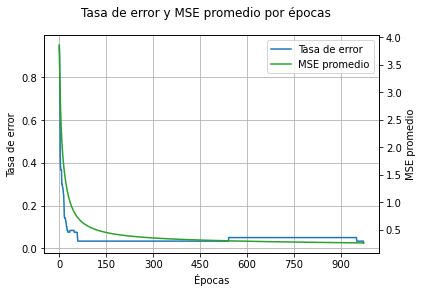

In [18]:
# Gráfica de la tasa de error por época junto con el MSE promedio por época
epochs = errorRatePerEpoch.shape[0]
xx_ = range(epochs)

fig1, fig1_ax = plt.subplots()
fig1.suptitle("Tasa de error y MSE promedio por épocas")
fig1_ax.set_xlabel('Épocas')
fig1_ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Solo ticks en enteros
fig1_ax.grid()
fig1_ax.set_ylabel('Tasa de error')

fig1_plot1 = fig1_ax.plot(xx_, errorRatePerEpoch, label='Tasa de error')

fig1_ax2 = fig1_ax.twinx()
fig1_plot2 = fig1_ax2.plot(xx_, MMSEPerEpoch, label='MSE promedio', color='C2')
fig1_ax2.set_ylabel('MSE promedio')

# added these three lines
lns = fig1_plot1+fig1_plot2
labs = [l.get_label() for l in lns]
fig1_ax.legend(lns, labs, loc=0)

plt.show()

### Test

In [19]:
# Procesar los datos para test
# Generar el vector de entradas para test
XTest = ds[testPartitionsIdx[0,:], :-y_num]
# Generar el vector de salida deseada para test
YdTest = ds[testPartitionsIdx[0,:], -y_num:]

mlp_in_test = np.zeros((XTest.shape[0], k))

# por cada patrón, se calcula la salida de la capa radial pasando por la RBF
for i, pattern in enumerate(XTest):


    _aux = [f_gaussian(pattern, _mean, _mu) for (_mean, _mu) in zip(means_vec, std_vec)]
    mlp_in_test[i] = _aux / np.linalg.norm(_aux)

errorsAccum_ = 0     # Acumulador de errores
for pattern, yd in zip(mlp_in_test, YdTest):
    # Calcular la salida
    (z_, _) = perceptron_simple.eval(pattern)
    
    # Codificación de la salida
        #CODIFICACION
    if z_[0] == z_.max():
        y_ = [1, -1, -1]
    elif z_[1] == z_.max():
        y_ = [-1, 1, -1]
    else:
            y_ = [-1, -1, 1]
    
    # Comparación con la salida deseada y acumulación de errores
    errorsAccum_ += int(np.any(np.not_equal(y_, yd)))

print(f'Tasa de error en prueba {errorsAccum_ / XTest.shape[0]}')

Tasa de error en prueba 0.06666666666666667


## ESTO FALTARÍA
resolver el problema Iris (`irisbin.csv`), considerando una cantidad de parámetros similar a la red MLP de la guía anterior. 
Luego compare la velocidad de entrenamiento y el porcentaje final de clasificación obtenido con ambas arquitecturas.